# problem statment
In a PUBG game, up to 100 players start in each match (matchId). 
Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) 
based on how many other teams are still alive when they are eliminated.
In game, players can pick up different munitions,
	revive downed-but-not-out (knocked) teammates,
	drive vehicles,
	swim,
	run,
	shoot,
	and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.


You are provided with a large number of anonymized PUBG game stats, 
formatted so that each row contains one player's post-game stats. 
The data comes from matches of all types: solos, duos, squads, and custom; 
there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from **1 (first place) to 0 (last place)**


**Data fields**

    DBNOs         - Number of enemy players knocked.
    assists       - Number of enemy players this player damaged that were killed by teammates.
    boosts        - Number of boost items used.
    damageDealt   - Total damage dealt. Note: Self inflicted damage is subtracted.
    headshotKills - Number of enemy players killed with headshots.
    heals         - Number of healing items used.
    Id            - Player’s Id
    killPlace     - Ranking in match of number of enemy players killed.
    killPoints    - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
    killStreaks   - Max number of enemy players killed in a short amount of time.
    kills         - Number of enemy players killed.
    longestKill   - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
    matchDuration - Duration of match in seconds.
    matchId       - ID to identify match. There are no matches that are in both the training and testing set.
    matchType     - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
    rankPoints    - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
    revives       - Number of times this player revived teammates.
    rideDistance  - Total distance traveled in vehicles measured in meters.
    roadKills     - Number of kills while in a vehicle.
    swimDistance  - Total distance traveled by swimming measured in meters.
    teamKills     - Number of times this player killed a teammate.
    vehicleDestroys   - Number of vehicles destroyed.
    walkDistance  - Total distance traveled on foot measured in meters.
    weaponsAcquired   - Number of weapons picked up.
    winPoints     - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
    groupId       - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
    numGroups     - Number of groups we have data for in the match.
    maxPlace      - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
    winPlacePerc  - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.


**Goal:** 

Perform the PUBG data analysis and answer the following questions:

- Does killing more people increases the chance of winning the game?
  - **Hint:** Use the correlation between the match winning percentage and number of kills to determine the relationship

- How do we catch the fraudsters in the game?
 - **Hint:** Use various logical conditions based on game knowledge to determine fraudsters in the game

- Can we predict the finishing position of a player in the game?
 - **Hint:** Regression Problem: Train and test a model using regression algorithm to predict the final position of the player at the end of the game. Create a model which **predicts players' finishing placement** based on their final stats, on a scale from 1 (first place) to 0 (last place).


In [1]:
# ! pip install downcast

In [1]:
# Importing the required libraries for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

###### reduce the memory usage of datafram

In [2]:
from downcast import reduce

# load your dataframe
train = pd.read_csv('train_V2.csv')
test = pd.read_csv('test_V2.csv')

# reduce the size of dataframe
train = reduce(train)
test = reduce(test)

In [3]:
#train.info(memory_usage='deep')
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype   
---  ------           -----   
 0   Id               category
 1   groupId          category
 2   matchId          category
 3   assists          int8    
 4   boosts           int8    
 5   damageDealt      float16 
 6   DBNOs            int8    
 7   headshotKills    int8    
 8   heals            int8    
 9   killPlace        int8    
 10  killPoints       int16   
 11  kills            int8    
 12  killStreaks      int8    
 13  longestKill      float16 
 14  matchDuration    int16   
 15  matchType        category
 16  maxPlace         int8    
 17  numGroups        int8    
 18  rankPoints       int16   
 19  revives          int8    
 20  rideDistance     float16 
 21  roadKills        int8    
 22  swimDistance     float16 
 23  teamKills        int8    
 24  vehicleDestroys  int8    
 25  walkDistance     float16 
 26  weaponsAcquire

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 28 columns):
 #   Column           Dtype   
---  ------           -----   
 0   Id               category
 1   groupId          category
 2   matchId          category
 3   assists          int8    
 4   boosts           int8    
 5   damageDealt      float16 
 6   DBNOs            int8    
 7   headshotKills    int8    
 8   heals            int8    
 9   killPlace        int8    
 10  killPoints       int16   
 11  kills            int8    
 12  killStreaks      int8    
 13  longestKill      float16 
 14  matchDuration    int16   
 15  matchType        category
 16  maxPlace         int8    
 17  numGroups        int8    
 18  rankPoints       int16   
 19  revives          int8    
 20  rideDistance     float16 
 21  roadKills        int8    
 22  swimDistance     float16 
 23  teamKills        int8    
 24  vehicleDestroys  int8    
 25  walkDistance     float16 
 26  weaponsAcquire

In [5]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [6]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46875,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.12500,0,0,2,11,...,1503,2,4668.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40625,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,788.0,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.50000,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.25000,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2964.0,4,0


### steps
**Part 1: Exploratory Data Analysis**
 
**Part 2: Data Cleaning: Outlier Detection and Removal - Finding the fraudsters**

**Part 3: Feature Engineering**

**Part 4: Final Predition**

In [7]:
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [8]:
test.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

In [4]:
train.dropna(inplace=True)

# part 1 - EDA and Feature Engineering

In [9]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [10]:
int_columns = train.columns

int_columns = int_columns.drop(['Id', 'groupId', 'matchId','matchType'])
int_columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

In [11]:
str_columns = ['Id', 'groupId', 'matchId','matchType']
str_columns

['Id', 'groupId', 'matchId', 'matchType']

In [12]:
corr = train[int_columns].corr()

<AxesSubplot:>

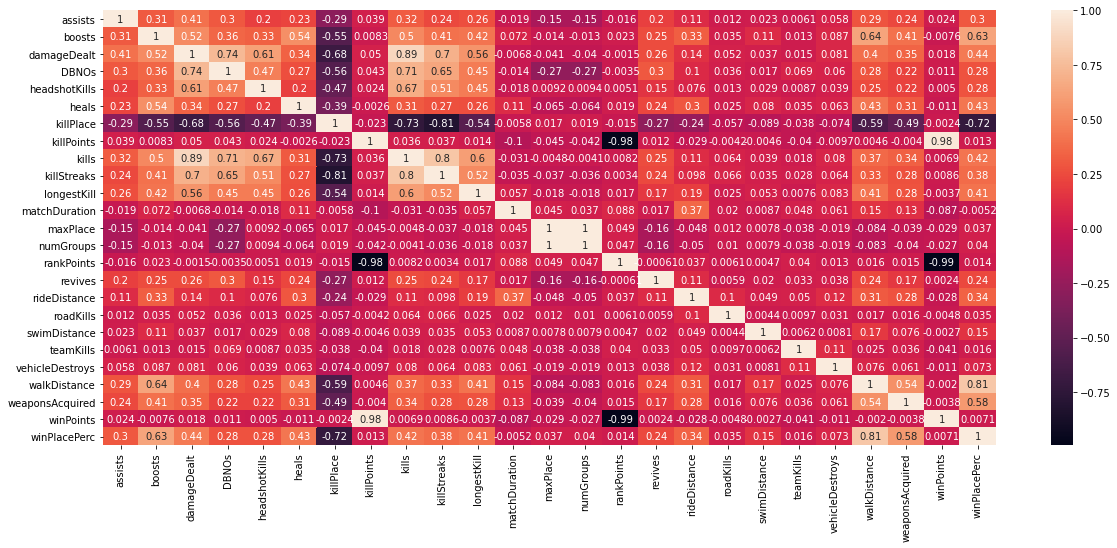

In [18]:
plt.figure(figsize=(20,8))
sns.heatmap(corr,annot=True)

#### features without zero correlation

In [13]:
def imp_feature_from_dataset(dataset):
    which_dataset = str(input('which is the input dataset (train or test): '))
    if which_dataset == 'train':
        return dataset[['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals','killPlace',
                    'kills', 'killStreaks', 'longestKill', 'revives','rideDistance', 'swimDistance',
                    'walkDistance', 'weaponsAcquired','winPlacePerc']]
    elif which_dataset =='test':
        return dataset[['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals','killPlace',
                    'kills', 'killStreaks', 'longestKill', 'revives','rideDistance', 'swimDistance',
                    'walkDistance', 'weaponsAcquired']]


In [14]:
train_0correlation = imp_feature_from_dataset(train)

which is the input dataset (train or test): train


In [101]:
train_0correlation.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,revives,rideDistance,swimDistance,walkDistance,weaponsAcquired,winPlacePerc
0,0,0,0.00000,0,0,0,60,0,0,0.00000,0,0.000000,0.000000,244.75,1,0.444336
1,0,0,91.50000,0,0,0,57,0,0,0.00000,0,0.004501,11.039062,1434.00,5,0.640137
2,1,0,68.00000,0,0,0,47,0,0,0.00000,0,0.000000,0.000000,161.75,2,0.775391
3,0,0,32.90625,0,0,0,75,0,0,0.00000,0,0.000000,0.000000,202.75,3,0.166748
4,0,0,100.00000,0,0,0,45,1,1,58.53125,0,0.000000,0.000000,49.75,2,0.187500


In [15]:
corr_0 = train_0correlation.corr()

<AxesSubplot:>

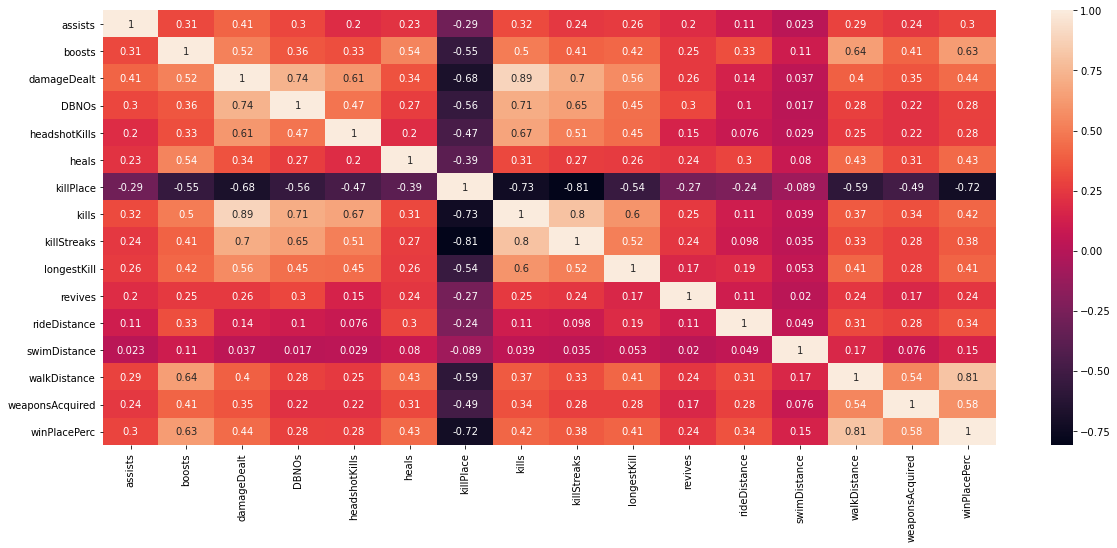

In [11]:
plt.figure(figsize=(20,8))
sns.heatmap(corr_0,annot=True)

** **
** **
## Q1-Does killing more people increases the chance of winning the game?
**the 42% kill is depends on the Winning**
** **
** **


** **
**below function provide the unique values and in addition to it if you want the values count or scatter plot(outliers detection)**
** **

In [16]:
def find_unique_value(dataset):
    print(dataset.columns)
    column_name = str(input('Enter the column name for which you want a unique value from above : '))
    print('\n',dataset[column_name].unique().shape)
    value_count = str(input('do you want value count : '))
    graph = str(input('do you want scatter graph  of this particual feature with other feature :'))
    if value_count == 'no' and graph == 'no':
        return print(sorted(dataset[column_name].unique()))
    elif value_count == 'yes' and graph == 'no':
        return dataset[column_name].value_counts()
    elif value_count == 'no' and graph == 'yes':
        other_graph_feature = str(input('other feature whom you want to make a graph with : '))
        plt.xlabel(column_name)
        plt.ylabel(other_graph_feature)
        plt.scatter(dataset[column_name],dataset[other_graph_feature])
        plt.show()
        str(input('some coment on above like Which range to take or any other <----->   '))
        more_graph = str(input('more graph of same feature with other : '))
        if more_graph == 'no':
            return
        elif more_graph == 'yes':
            how_many = int(input('how many more graph you want after this : '))
            for i in range(0,how_many):
                other_graph_feature = str(input('other feature whom you want to make a graph with : '))
                plt.xlabel(column_name)
                plt.ylabel(other_graph_feature)
                plt.scatter(dataset[column_name],dataset[other_graph_feature])
                plt.show()
                str(input('some coment on above like Which range to take or any other <----->   '))



Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired',
       'winPlacePerc'],
      dtype='object')
Enter the column name for which you want a unique value from above : assists

 (20,)
do you want value count : no
do you want scatter graph  of this particual feature with other feature :yes
other feature whom you want to make a graph with : kills


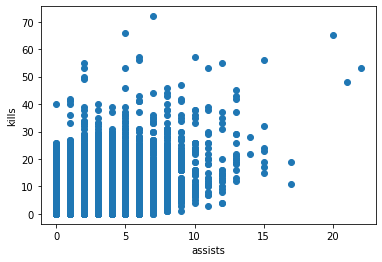

some coment on above like Which range to take or any other <----->   kill range --> 0-(between 30 and 40) and assists range --> 0-(between 12 to 15))
more graph of same feature with other : no
how many more graph you want after this : 0


In [17]:
find_unique_value(train_0correlation)

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired',
       'winPlacePerc'],
      dtype='object')
Enter the column name for which you want a unique value from above : kills

 (58,)
do you want value count : no
do you want scatter graph  of this particual feature with other feature :yes
other feature whom you want to make a graph with : headshotKills


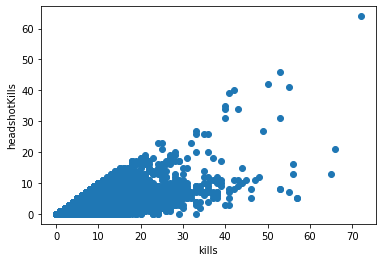

some coment on above like Which range to take or any other <----->   headshotKills range -->> 0-(20-30) and kill range -->> 0-(30,40)
more graph of same feature with other : yes
how many more graph you want after this : 6
other feature whom you want to make a graph with : boosts


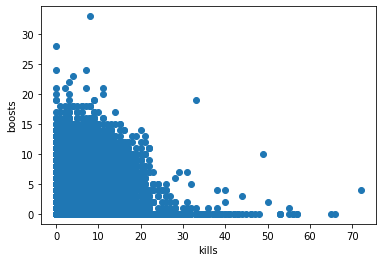

some coment on above like Which range to take or any other <----->   boosts range -->> 0-(20-25) kills range -->> 0-(30,40)
other feature whom you want to make a graph with : heals


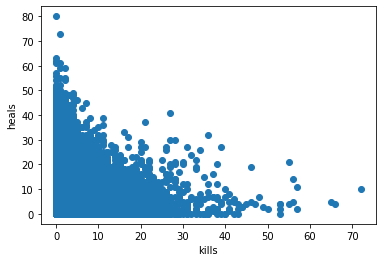

some coment on above like Which range to take or any other <----->   heals range --> 0-(50,60) kills range --> 0-(35,45)
other feature whom you want to make a graph with : killStreaks


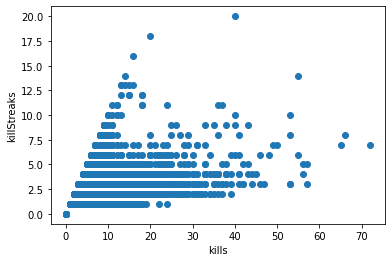

some coment on above like Which range to take or any other <----->   killStraks range --> 0-(15,18) kil range --> 0-(45,52)
other feature whom you want to make a graph with : swimDistance


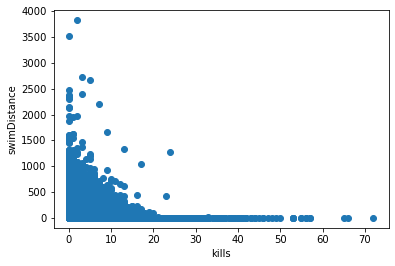

some coment on above like Which range to take or any other <----->   swimDistance --> 0-(1300,1700) kill range --> 0-(20,27)
other feature whom you want to make a graph with : walkDistance


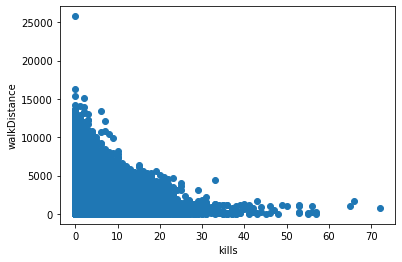

some coment on above like Which range to take or any other <----->   walkDistance --> 500,-(1500,1700) kill range --> 0-(30,40)
other feature whom you want to make a graph with : damageDealt


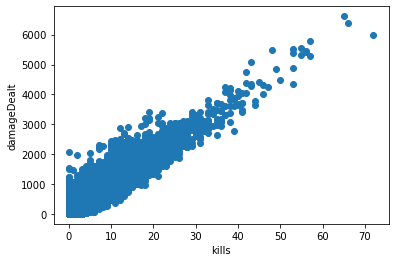

some coment on above like Which range to take or any other <----->   damageDealt range --> 0-(5000,6000) and kill range --> 0-(50,60)


In [21]:
find_unique_value(train_0correlation)

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired',
       'winPlacePerc'],
      dtype='object')
Enter the column name for which you want a unique value from above : heals

 (63,)
do you want value count : no
do you want scatter graph  of this particual feature with other feature :yes
other feature whom you want to make a graph with : damageDealt


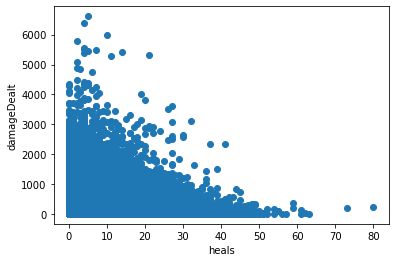

some coment on above like Which range to take or any other <----->   so much damage with zero heals is not possible and the also for zero damage and so much                             damageDealt range --> (300,700)-5000 and kill range  0-(30,40)
more graph of same feature with other : boosts


In [22]:
find_unique_value(train_0correlation)

** **
**from above graphs we can conclued that**
    
    kill range should we between 0-(30 to 40)
    swimDistance should be between 0-(1300, 1700)
    walkDistance --> 51,-(1500,1700)
    damageDealt range --> 0-5000
    heals range --> 0-(50,60)
    boosts range -->> 0-(20-25)
    assists range --> 0-(between 12 to 15))
    headshotKills range -->> 0-(20-30)

** **

**checking the p values for feaure extraction**

In [18]:
import statsmodels.api as sm
# exrtacing the features using the p_value

p_value = sm.OLS(train_0correlation['winPlacePerc'],sm.add_constant(train_0correlation.drop(['winPlacePerc'],axis = 'columns')))


p_value.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           winPlacePerc   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                 1.228e+06
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:20:28   Log-Likelihood:             2.5761e+06
No. Observations:             4446965   AIC:                        -5.152e+06
Df Residuals:                 4446949   BIC:                        -5.152e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7194      0.000   1758.326      0.000       0.719       0.720
assists             0.0135      0.000    109.488      0.000       0.013       0.014
boosts              0.0180   5.69e-05    316.163      0.000       0.018       0.018
damageDealt      7.546e-05   9.24e-07     81.668      0.000    7.36e-05    7.73e-05
DBNOs              -0.0176    8.8e-05   -200.308      0.000      -0.018      -0.017
headshotKills       0.0020      0.000     13.798      0.000       0.002       0.002
heals           -7.754e-05   2.93e-05     -2.647      0.008      -0.000   -2.01e-05
killPlace          -0.0074    5.2e-06  -1419.006      0.000      -0.007      -0.007
kills              -0.0090      0.000    -77.102      0.000      -0.009      -0.009
killStreaks        -0.1383      0.000   -695.020      0.000      -0.139      -0.138
longestKill     -1.601e-05   1.66e-06     -9.675      0.000   -1.93e-05   -1.28e-05
revives             0.0096      0.000     65.513      0.000       0.009       0.010
rideDistance     7.351e-06   4.72e-08    155.774      0.000    7.26e-06    7.44e-06
swimDistance        0.0001   2.14e-06     67.132      0.000       0.000       0.000
walkDistance        0.0001   8.52e-08   1263.915      0.000       0.000       0.000
weaponsAcquired     0.0098   3.31e-05    296.608      0.000       0.010       0.010
==============================================================================
Omnibus:                   325702.513   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1578954.373
Skew:                          -0.178   Prob(JB):                         0.00
Kurtosis:                       5.897   Cond. No.                     1.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


**seems data with zero correaltion are the right choice to select the data**


# Part 2: Data Cleaning: Outlier Detection and Removal - Finding the fraudsters


In [17]:
train_clean = train_0correlation.copy(deep=True)
train_clean.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,revives,rideDistance,swimDistance,walkDistance,weaponsAcquired,winPlacePerc
0,0,0,0.00000,0,0,0,60,0,0,0.00000,0,0.000000,0.000000,244.75,1,0.444336
1,0,0,91.50000,0,0,0,57,0,0,0.00000,0,0.004501,11.039062,1434.00,5,0.640137
2,1,0,68.00000,0,0,0,47,0,0,0.00000,0,0.000000,0.000000,161.75,2,0.775391
3,0,0,32.90625,0,0,0,75,0,0,0.00000,0,0.000000,0.000000,202.75,3,0.166748
4,0,0,100.00000,0,0,0,45,1,1,58.53125,0,0.000000,0.000000,49.75,2,0.187500


** **
**removing the outliers**

In [25]:
find_unique_value(train)

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')
Enter the column name for which you want a unique value from above : headshotKills

 (34,)
do you want value count : no
do you want scatter graph  of this particual feature with other feature :no
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 27, 31, 34, 35, 39, 40, 41, 42, 46, 64]


In [20]:
headshotFraud = train_clean[train_clean.headshotKills>=27]

In [28]:
find_unique_value(train_clean)

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired',
       'winPlacePerc'],
      dtype='object')
Enter the column name for which you want a unique value from above : kills

 (58,)
do you want value count : no
do you want scatter graph  of this particual feature with other feature :no
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 55, 56, 57, 65, 66, 72]


In [21]:
killFraud = train_clean[train_clean.kills>=39]

In [30]:
find_unique_value(train_0correlation)

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired',
       'winPlacePerc'],
      dtype='object')
Enter the column name for which you want a unique value from above : swimDistance

 (12589,)
do you want value count : no
do you want scatter graph  of this particual feature with other feature :no
[0.0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.0011, 0.0013, 0.0014, 0.0015, 0.0016, 0.0018, 0.0019, 0.002, 0.0021, 0.0022, 0.0023, 0.0024, 0.0027, 0.0028, 0.0029, 0.003, 0.0031, 0.0032, 0.0033, 0.0034, 0.0035, 0.0037, 0.0038, 0.0039, 0.004, 0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0047, 0.0048, 0.005, 0.0051, 0.0053, 0.0055, 0.0057, 0.0058, 0.0059, 0.0061, 0.0062, 0.0065, 0.0067, 0.0068, 0.0069, 0.007, 0.0071, 0.0072, 0.0073, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079, 0.008, 0.0081, 0.0083, 0.0084

In [22]:
swimFraud = train_clean[train_clean.swimDistance>1700]

**above i have picked the expected outliers from the random feature**
****

In [18]:
train_cleaned = train_clean.copy()

In [19]:
train_cleaned = train_cleaned[train_cleaned.kills<30]  
## removing the kill outliers

In [20]:
train_cleaned = train_cleaned[train_cleaned.headshotKills<20]  
## removing the headshots outliers after kill outliers

In [21]:
train_cleaned = train_cleaned[train_cleaned.swimDistance<1500]  
## removing the swimdistance outliers after kill outliers and headshot outliers

** **
** **
## Q2 - How do we catch the fraudsters in the game?
        if a person kill more than 10 or with zero walk distance
        if a person doesn't doesn't use heals or boosts with kill more than 20 or for pro player 30
        if a person kill more than 30 and at the same time assists in also more than 10
        if a person assists someone and his damage delta is still zero
        if a person per kills other with more than headshot in a killstreak more than 5 or 10
**person full fill these critaria then a person can be treated as fraudster**
** **
** **


In [14]:
f'{train_cleaned.shape} -------- {train_clean.shape}'

'(4446819, 16) -------- (4446965, 16)'

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired',
       'winPlacePerc'],
      dtype='object')
Enter the column name for which you want a unique value from above : assists

 (17,)
do you want value count : no
do you want scatter graph  of this particual feature with other feature :yes
other feature whom you want to make a graph with : revives


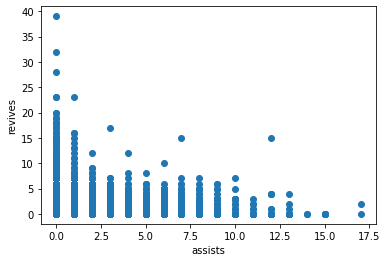

some coment on above like Which range to take or any other <----->   revives range --> 0-23
more graph of same feature with other : no


In [37]:
find_unique_value(train_cleaned)

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired',
       'winPlacePerc'],
      dtype='object')
Enter the column name for which you want a unique value from above : kills

 (30,)
do you want value count : no
do you want scatter graph  of this particual feature with other feature :yes
other feature whom you want to make a graph with : assists


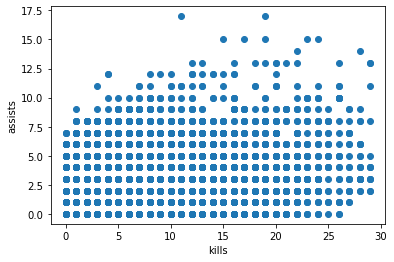

some coment on above like Which range to take or any other <----->   it is fine now
more graph of same feature with other : yes
how many more graph you want after this : 8
other feature whom you want to make a graph with : boosts


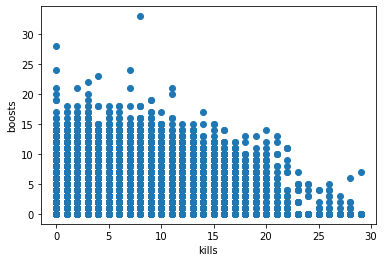

some coment on above like Which range to take or any other <----->   edit boosts range
other feature whom you want to make a graph with : damageDealt


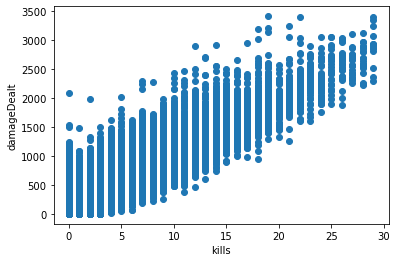

some coment on above like Which range to take or any other <----->   it is nice
other feature whom you want to make a graph with : heals


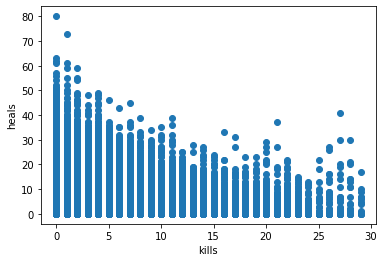

some coment on above like Which range to take or any other <----->   better
other feature whom you want to make a graph with : revives


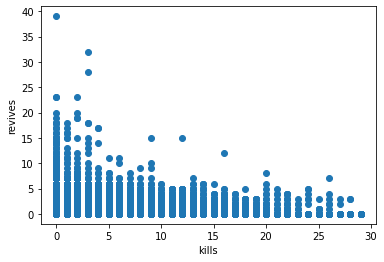

some coment on above like Which range to take or any other <----->   revive range should be changed
other feature whom you want to make a graph with : weaponsAcquired


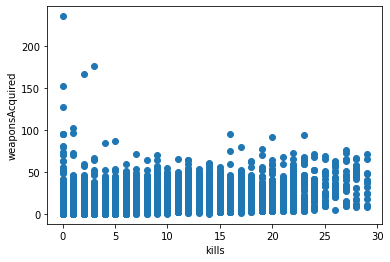

some coment on above like Which range to take or any other <----->   wepons accuried range --> 0-100
other feature whom you want to make a graph with : walkDistance


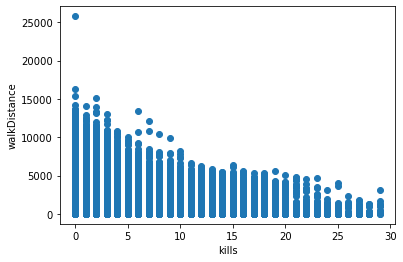

some coment on above like Which range to take or any other <----->   walk distance range change 
other feature whom you want to make a graph with : swimDistance


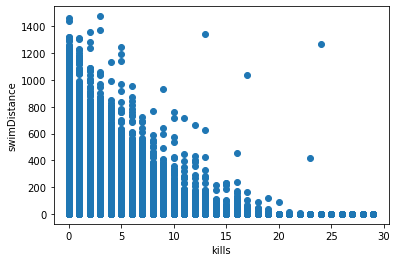

some coment on above like Which range to take or any other <----->   winPlacePerc
other feature whom you want to make a graph with : winPlacePerc


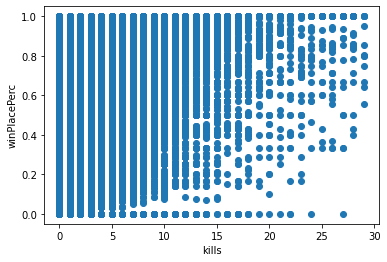

some coment on above like Which range to take or any other <----->   nice


In [38]:
find_unique_value(train_cleaned)

**now again removing some range**

In [22]:
train_cleaned = train_cleaned[train_cleaned.kills<=27]

In [23]:
train_cleaned = train_cleaned[train_cleaned.walkDistance<=17000]

In [24]:
train_cleaned = train_cleaned[train_cleaned.swimDistance<=1300]

In [25]:
train_cleaned = train_cleaned[train_cleaned.revives<=27]

In [27]:
train_cleaned.describe(percentiles=[0.75,0.95,0.97,0.99]).round(2)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,revives,rideDistance,swimDistance,walkDistance,weaponsAcquired,winPlacePerc
count,4446769.00,4446769.00,4446769.00,4446769.00,4446769.00,4446769.00,4446769.00,4446769.00,4446769.00,4446769.00,4446769.00,4446769.00,4446769.00,4446769.0,4446769.00,4446769.00
mean,0.23,1.11,NaN,0.66,0.23,1.37,47.60,0.92,0.54,NaN,0.16,NaN,NaN,NaN,3.66,NaN
std,0.59,1.72,NaN,1.14,0.60,2.68,27.46,1.54,0.71,NaN,0.47,NaN,NaN,NaN,2.45,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
50%,0.00,0.00,84.25,0.00,0.00,0.00,47.00,0.00,0.00,0.00,0.00,0.00,0.00,685.5,3.00,0.46
75%,0.00,2.00,186.00,1.00,0.00,2.00,71.00,1.00,1.00,21.31,0.00,0.19,0.00,1976.0,5.00,0.74
95%,1.00,5.00,459.00,3.00,1.00,7.00,91.00,4.00,2.00,126.00,1.00,4048.00,11.42,3396.0,8.00,0.96
97%,2.00,6.00,556.00,3.00,2.00,8.00,93.00,5.00,2.00,166.12,1.00,5080.00,42.59,3714.0,9.00,0.99
99%,3.00,7.00,775.50,5.00,3.00,12.00,96.00,7.00,3.00,243.75,2.00,6968.00,122.88,4396.0,10.00,1.00
max,17.00,33.00,3408.00,33.00,19.00,80.00,101.00,27.00,18.00,1094.00,23.00,40704.00,1294.00,16248.0,236.00,1.00


In [44]:
train_cleaned[train_cleaned.damageDealt==train_cleaned.damageDealt.max()]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,revives,rideDistance,swimDistance,walkDistance,weaponsAcquired,winPlacePerc
118502,4,7,3408.0,21,2,8,1,19,3,580.5,1,572.5,0.0,3182.0,5,0.958496


In [26]:
train_cleaned.drop_duplicates(inplace = True)

In [27]:
train_cleaned.dropna(inplace=True)

****

### Modeling

**now the data is cleaned and ready for scaling and modeling**

In [28]:
X = train_cleaned.drop(['winPlacePerc'],axis = 'columns')
Y = train_cleaned['winPlacePerc']

(X.shape),(Y.shape)

((4345514, 15), (4345514,))

In [29]:
X.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired'],
      dtype='object')

**using MinMaxScaler because it provide range between 0-1 and take max value as 1 and min value as 0. It also provide the ppositive values which help modeling fast**

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


In [31]:
def scaling_dataset(x):
    scaled = scaler.fit_transform(X)
    scaled = pd.DataFrame(scaled)
    scaled.columns = X.columns
    return scaled

In [32]:
X_scaled = scaling_dataset(X)

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=3)
(x_train.shape),(y_train.shape),(x_test.shape),(y_test.shape)


((3476411, 15), (3476411,), (869103, 15), (869103,))

**PCA (Principal Compounent Analysis)**
    
    for reducing the features and finding the best featuer for traning the model

In [35]:
from sklearn.decomposition import PCA

pca = PCA()
pca_x_train = pca.fit_transform(x_train)

labels = {
    str(i): var
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}


In [36]:
pca_x_test = pca.transform(x_test)
pca_x_test.shape

(869103, 15)

In [37]:
labels

{'0': 83.58597975510203,
 '1': 4.60807389183332,
 '2': 3.67558620675299,
 '3': 1.456670749393603,
 '4': 1.2952977933213836,
 '5': 1.0610267107790563,
 '6': 0.9835827921633199,
 '7': 0.7212509690449055,
 '8': 0.5960722352536718,
 '9': 0.5385375320780905,
 '10': 0.4443374245692239,
 '11': 0.3903068925565756,
 '12': 0.3515842849817241,
 '13': 0.22274271668341591,
 '14': 0.06895004548671083}

In [38]:
(pca_x_train.shape),(pca_x_test.shape)

((3476411, 15), (869103, 15))

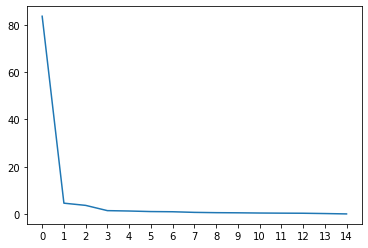

In [39]:
plt.plot(labels.keys(),labels.values())

In [40]:
np.any(np.isnan(y_train))

False

In [41]:
np.any(np.isnan(pca_x_train))

False

**PLS regression**

In [42]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=15)
pls_train = pls.fit_transform(pca_x_train,y_train)


In [43]:
pls_pred = pls.predict(pca_x_test)

In [44]:
(np.array(pls_train).shape),(y_train.shape)

((2, 3476411, 15), (3476411,))

In [45]:
(pls_pred.shape),(y_test.values.reshape(-1,1).shape)

((869103, 1), (869103, 1))

In [46]:
np.array(pls_train)

array([[[-1.13978914e+00,  4.94981166e-01, -6.33359505e-01, ...,
          5.76198830e-03,  2.74878825e-04,  1.07853810e-03],
        [-1.18864756e+00,  2.04285023e-01, -7.97851163e-02, ...,
         -9.09752170e-04, -3.65027416e-04,  6.74173389e-06],
        [-7.40224681e-02, -9.40963287e-01,  2.71997748e-02, ...,
          3.63541053e-06,  4.23964157e-04, -1.81652618e-03],
        ...,
        [ 1.05566369e+00, -1.33137736e-01,  7.71196762e-01, ...,
         -1.90658538e-03, -1.93793593e-03, -5.13457882e-03],
        [ 2.52164067e-01, -1.15201989e+00, -4.86201258e-01, ...,
         -4.45076703e-04, -8.83280841e-04,  1.43584621e-03],
        [-9.94265937e-01,  6.82420381e-02, -2.71750129e-01, ...,
         -2.39553324e-04, -9.61957494e-05, -8.56446325e-04]],

       [[-1.55118325e+00, -1.08404656e-04, -3.55022234e-09, ...,
          3.16949384e-16, -8.24164983e-15, -2.72615593e-14],
        [-1.62218811e+00, -1.13366841e-04, -3.71273252e-09, ...,
          3.31457630e-16, -8.61890845e

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor,PoissonRegressor

In [48]:
lr = LinearRegression()
sgd = SGDRegressor()
poisson = PoissonRegressor()
dt = DecisionTreeRegressor(random_state=3)

In [49]:
models = {'linear' : lr,
          'decision_tree' : dt,
          'sgd' : sgd,
          'poisson' : poisson}

In [50]:
score = {}
predicted = {}
for i in models.keys():
    predicted[i] = models[i].fit(x_train,y_train).predict(x_test)
    score[i] = models[i].fit(x_train,y_train).score(x_train,y_train)

In [51]:
score

{'linear': 0.7991705998573002,
 'decision_tree': 0.9982726965453689,
 'sgd': 0.7950709343313088,
 'poisson': 0.03420095992333472}

In [52]:
y_test = pd.DataFrame(y_test)
y_test.reset_index(drop=True,inplace=True)

In [53]:
predicted = pd.DataFrame(predicted)
result = pd.concat([predicted,y_test],axis='columns')
result.head()

,linear,decision_tree,sgd,poisson,winPlacePerc
0,0.307589,0.080017,0.327288,0.484828,0.276611
1,0.779532,1.000000,0.818801,0.497177,0.915039
2,0.066413,0.031891,0.082304,0.470473,0.021301
3,0.350387,0.362549,0.355647,0.478847,0.629395
4,0.314980,0.074097,0.334490,0.485842,0.192261


****

In [54]:
from sklearn.metrics import r2_score

r2_score_test = {}

for i in result.columns:
    if i != 'winPlacePerc':
        r2_score_test[i] = r2_score(result['winPlacePerc'].values.reshape(-1,1),result[i].values.reshape(-1,1))

#print(r2_score(y_test.values.reshape(-1,1),pls_pred.reshape(-1,1)))


In [55]:
r2_score_test['pls'] = r2_score(y_test.values.reshape(-1,1),pls_pred.reshape(-1,1))

In [56]:
r2_score_test

{'linear': 0.7987551193267912,
 'decision_tree': 0.7775121285851563,
 'sgd': 0.7946611060514115,
 'poisson': 0.039377584884707884,
 'pls': 0.7987551440971967}

** **
### looks like the linear regression and Pricipal least square worked better than other with as r2 score of 79.87% on test dataset and we are using the linear regression because PLS we have to do inverse transor of the test dataset

**Part 4: Final Predition**

In [57]:
x_train_final = X
y_train_final = Y

In [58]:
test_final = imp_feature_from_dataset(test)
test_final = scaling_dataset(test_final)

which is the input dataset (train or test): test


In [59]:
print(test_final.columns)
test_final.head()

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired'],
      dtype='object')


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,revives,rideDistance,swimDistance,walkDistance,weaponsAcquired
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.59,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.015063,0.004237
1,0.000000,0.0,0.026849,0.0,0.0,0.0,0.56,0.000000,0.000000,0.000000,0.0,1.105872e-07,0.008531,0.088257,0.021186
2,0.058824,0.0,0.019953,0.0,0.0,0.0,0.46,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.009955,0.008475
3,0.000000,0.0,0.009656,0.0,0.0,0.0,0.74,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.012478,0.012712
4,0.000000,0.0,0.029343,0.0,0.0,0.0,0.44,0.037037,0.055556,0.053502,0.0,0.000000e+00,0.000000,0.003062,0.008475


**final prediction**

In [76]:
final_pred = lr.fit(x_train_final,y_train_final).predict(test_final)

In [77]:
final_pred = pd.DataFrame(final_pred)

In [78]:
final_pred.head()

,0
0,0.726119
1,0.726510
2,0.727926
3,0.725077
4,0.719100


In [80]:
final_pred.describe().round(3)

,0
count,4345514.000
mean,0.744
std,0.021
min,0.587
25%,0.721
50%,0.724
75%,0.726
max,0.744


In [81]:
submission = final_pred

In [82]:
submission[submission >= submission.quantile(0.5)] = 1
submission[submission < submission.quantile(0.5)] = 0

In [88]:
submission = pd.concat([test.Id,submission],axis='columns')

In [91]:
submission.columns = ['unique id','winPlacePerc']

In [93]:
submission.head()

,unique id,winPlacePerc
0,9329eb41e215eb,1.0
1,639bd0dcd7bda8,1.0
2,63d5c8ef8dfe91,1.0
3,cf5b81422591d1,1.0
4,ee6a295187ba21,0.0


In [94]:
submission.to_csv('submission.csv')

<AxesSubplot:>

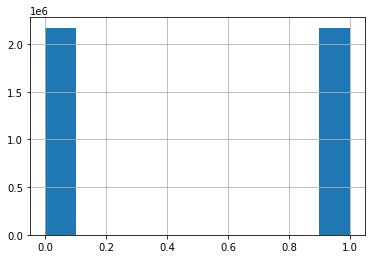

In [87]:
submission['winPlacePerc'].hist()